# CnnGRU-based VAD

# Датасеты


#### LibriSpeech
Для тренировки испольован раздел `dev-clean.tar.gz` http://www.openslr.org/12/.. Для использования в скрипте архив необходимо распаковать, не меняя структуры.

#### QUT-NOISE
Датасет использован целиком https://research.qut.edu.au/saivt/databases/qut-noise-databases-and-protocols/. ДЛя использования необходимо скачать все архивы и распакаовать их в одну папку. О задании путей до них - ниже в коде

# Запуск и тренировка

Модель можно натренировать с нуля, используя вышеуказанные датасеты, можно использовать приложенный в папке models чекпойнт. О тренировке и использовании - также ниже

В ноутбуке используются глобальные переменные (капсом), с их помощью можно котролировать параметры, а так же указывать, хотим ли мы препроцессить данные, тренировать или нет модели и т.д.

# Рабочая директория
Директория, из которой запускаются данные и где будут храниться файлы препроцессинга

In [1]:
path_peer = r'D:\vk_test'

We can then proceed to check which directory to use. If everything goes right, you will see your path echoed in the output.

In [2]:
import os

os.chdir(path_peer)
print('Directory is set to', os.getcwd())

Directory is set to D:\vk_test


# Необходимые библиотеки.
Раскомментить, если необходимо установить.

In [3]:
# !pip install SoundFile
# !pip install webrtcvad
# !pip install pydub
# !pip install python_speech_features
# !pip install h5py
# !pip install h5py_cache

# Настройки препроцессинга

Глобальные константы

In [4]:
# реформатирование аудио
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2

# путь до файлов препроцессинга
DATA_FOLDER = r'D:\vk_test\data'

# Слайсинг входных данных.
SLICE_MIN_MS = 1000
SLICE_MAX_MS = 5000

# Длина фрейма для лейбла.
FRAME_SIZE_MS = 10

# Слайсы по размеру фрейма.
SLICE_MIN = int(SLICE_MIN_MS / FRAME_SIZE_MS)
SLICE_MAX = int(SLICE_MAX_MS / FRAME_SIZE_MS)

FRAME_SIZE = int(SAMPLE_RATE * (FRAME_SIZE_MS / 1000.0))

# Глобальные переменные для запуска


`OBJ_PREPARE_AUDIO` - если True, то препроцессим данные, если False - используем уже сохраненные результаты препроцессинга <br/>
`OBJ_TRAIN_MODELS` - если True, то тренируем модель заново, иначе используем сохраненную.<br/>
`OBJ_CUDA` - работаем на гпу или на цпу.

In [106]:
import torch

OBJ_CUDA = torch.cuda.is_available()

OBJ_PREPARE_AUDIO = True
OBJ_TRAIN_MODELS = True

if OBJ_CUDA:
    print('CUDA has been enabled.')
else:
    print('CUDA has been disabled.')

CUDA has been enabled.


# Подготовка датасетов
Унифицирует данные (в том числе для использования с webrtc) и хранит их в hdf5 формате для быстрого доступа к любому их сегменту. Если данные уже обработаны, процесс автоматически пропускается


In [6]:
import glob
import re
from pydub import AudioSegment
import soundfile as sf
import h5py
import numpy as np
import webrtcvad

class FileManager:
    
    def __init__(self, name, directory):
        
        self.name = name
        self.data = h5py.File(DATA_FOLDER + '/' + name + '.hdf5', 'a')
        
        # собираем имена файлов.
        if 'files' not in self.data:
        
            # собираем сами файлы.
            files = glob.glob(directory + '/**/*.wav', recursive=True)
            files.extend(glob.glob(directory + '/**/*.flac', recursive=True))
            files = [f for f in files]
            
            # создаем файл датасета.
            dt = h5py.special_dtype(vlen=str)
            self.data.create_dataset('files', (len(files),), dtype=dt)
            
            # и добавляем имена.
            for i, f in enumerate(files):
                self.data['files'][i] = f
        
    def get_track_count(self):
        return len(self.data['files'])

    def prepare_files(self, normalize=False):
        '''
        Подготовка файлов. Конвертирует всё в WAV, съедобный для WebRTC
        (так как питоновская реализация очень капризная к формату)
        
        '''
        
        if not OBJ_PREPARE_AUDIO:
            print(f'Skipping check for {self.name}.')
            return
        
        print('Found {0} tracks to check.'.format(self.get_track_count()))
        progress = 1
        
        # датасет исходных сырых данных.
        if 'raw' not in self.data:
            dt = h5py.special_dtype(vlen=np.dtype(np.int16))
            self.data.create_dataset('raw', (self.get_track_count(),), dtype=dt)
        
        # конвертируем и сохраняем оригинал.
        for i, file in enumerate(self.data['files']):
            
            print('Processing {0} of {1}'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1

            if len(self.data['raw'][i]) > 0:
                continue
 
            track = (AudioSegment.from_file(file.decode("utf-8"))
                     .set_frame_rate(SAMPLE_RATE)
                     .set_sample_width(SAMPLE_WIDTH)
                     .set_channels(SAMPLE_CHANNELS))

            if normalize:
                track = track.apply_gain(-track.max_dBFS)

            self.data['raw'][i] = np.array(track.get_array_of_samples(), dtype=np.int16)
            
        self.data.flush()
        print('\nDone!')
        
    def collect_frames(self):
        '''
        Собираем все аудио в один длинный массив для последующего сэмплинга
        '''
      
        if 'frames' in self.data:
            print('Frame merging already done. Skipping.')
            return
        
        if 'raw' not in self.data:
            print('Could not find raw data!')
            return
        
        frame_count = 0
        progress = 1
        
        # считаем количество необходимых фреймов.
        for raw in self.data['raw']:
            frame_count += int((len(raw) + (FRAME_SIZE - (len(raw) % FRAME_SIZE))) / FRAME_SIZE)
            print('Counting frames ({0} of {1})'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1
            
        # датасет для фреймов.
        dt = np.dtype(np.int16)
        self.data.create_dataset('frames', (frame_count, FRAME_SIZE), dtype=dt)
        
        progress = 0

        buffer = np.array([])
        buffer_limit = FRAME_SIZE * 4096
        
        # мерджим.
        for raw in self.data['raw']:
            
            # падим исходные данные под длину фрейма.
            raw = np.concatenate((raw, np.zeros(FRAME_SIZE - (len(raw) % FRAME_SIZE))))
            
            buffer = np.concatenate((buffer, raw))
            
            # Добиваем буфер до полного
            if len(buffer) < buffer_limit and progress + (len(buffer) / FRAME_SIZE) < frame_count:
                continue
            
            # берем фремы из буфера.
            frames = np.array(np.split(buffer, len(buffer) / FRAME_SIZE))
            buffer = np.array([])
            
            # добавляем.
            self.data['frames'][progress : progress + len(frames)] = frames
            
            progress += len(frames)
            print('Merging frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
            
        self.data.flush()
        print('\nDone!')
        
    def label_frames(self):
        '''
        Искусственно размечаем данные с помощью WebRTC
        '''
        
        if 'labels' in self.data:
            print('Frame labelling already done. Skipping.')
            return
        
        if 'frames' not in self.data:
            print('Could not find any frames!')
            return
        
        vad = webrtcvad.Vad(0)
        
        frame_count = len(self.data['frames'])
        progress = 0
        batch_size = 65536
        
        # датасет для лейблов.
        dt = np.dtype(np.uint8)
        self.data.create_dataset('labels', (frame_count,), dtype=dt)
        
        # считаем лейблы для всех фреймов.
        for pos in range(0, frame_count, batch_size):
            
            frames = self.data['frames'][pos : pos + batch_size]
            labels = [1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames]
            self.data['labels'][pos : pos + batch_size] = np.array(labels)
            
            progress += len(labels)
            print('Labelling frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
        
        self.data.flush()
        print('\nDone!')
        
print('Loading files...')
speech_dataset = FileManager('speech', r'D:\Datasets\libri_small')

noise_dataset = FileManager('noise', r'D:\Datasets\noises\qutnoise')

speech_dataset.prepare_files()
noise_dataset.prepare_files(normalize=True)

print('Collecting frames...')

speech_dataset.collect_frames()
noise_dataset.collect_frames()

print('Labelling frames...')
speech_dataset.label_frames()

Loading files...
Found 2703 tracks to check.
Processing 2703 of 2703
Done!
Found 20 tracks to check.
Processing 20 of 20
Done!
Merging frames (1941719 of 1941719)
Done!
Merging frames (4913159 of 4913159)
Done!
Labelling frames...
Labelling frames (1941719 of 1941719)
Done!


# Конструктор данных


Теперь мы можем использовать все данные для построения датасета. Будем подмешивать шум на двух уровнях: -15, -3, а так же данные без шума. В качестве фичей будем использовать MFCC с двумя дельтами, размер фрейма в 10 мс позволяет при этом уложиться в задержку 40 мс. Все собранные данные будем хранить в `data.hdf5`.


In [7]:
import python_speech_features
import array
import h5py_cache
import math

data = h5py_cache.File(DATA_FOLDER + '/data.hdf5', 'a', chunk_cache_mem_size=1024**3)
noise_levels_db = { 'None': None, '-15': -15, '-3': -3 }

mfcc_window_frame_size = 4

speech_data = speech_dataset.data
noise_data = noise_dataset.data

np.random.seed(1337)

def add_noise(speech_frames, noise_frames, align_frames, noise_level_db):
    
    # конвертируем в треки.
    
    
    speech_track = (AudioSegment(data=array.array('h', speech_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    noise_track = (AudioSegment(data=array.array('h', noise_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    
#     speech_track = speech_frames.flatten()
#     noise_track = noise_frames.flatten()
    
    
    # вычисляем коэффициент для шума, исходя из SNR в децибелах
#     def from_db(ratio_db):
#         ratio = 10 ** (ratio_db / 10.) - 1e-8
#         return ratio


#     def coef_by_snr(src_audio, ns_audio, snr):
#         src_audio = src_audio
#         ns_audio = ns_audio
#         try:
#             target_snr_n = from_db(snr)
#             ns_target_sq = np.mean(src_audio ** 2) / target_snr_n
#             ns_mult = math.sqrt(ns_target_sq / np.mean(ns_audio ** 2))
#             abs_max = ns_mult * np.abs(ns_audio).max()
#             if abs_max > 1.:
#                 ns_mult /= abs_max
#         except:
#             ns_mult = 0
#         return ns_mult
    
    # накладываем шум.
    track = noise_track.overlay(speech_track, gain_during_overlay=noise_level_db)
#     track = np.add(speech_track, noise_track*coef_by_snr(speech_track, noise_track, noise_level_db))
#     track = speech_track + noise_track*coef_by_snr(speech_track, noise_track, noise_level_db)

    # обратно во фреймы.
    raw = np.array(track.get_array_of_samples(), dtype=np.int16)
#     raw = track
#     print(raw.shape)
    frames = np.array(np.split(raw, len(raw) / FRAME_SIZE))
    
    # добавляем предыдущие для MFCC
    frames_aligned = np.concatenate((align_frames, frames))
    
    mfcc = python_speech_features.mfcc(frames_aligned, SAMPLE_RATE, winstep=(FRAME_SIZE_MS / 1000), 
                                       winlen=mfcc_window_frame_size * (FRAME_SIZE_MS / 1000), nfft=2048)

    # в этой библиотеке первая фича - энергия.
    mfcc = mfcc[:, 1:]
    delta = python_speech_features.delta(mfcc, 2)
    
    return frames, mfcc, delta
    
if 'labels' not in data:

    print('Shuffling speech data and randomly adding 50% silence.')
    
    pos = 0
    l = len(speech_dataset.data['frames'])
    slices = []
     
    # Бьем рандомно в пределах заданных размеров слайса
    while pos + SLICE_MIN < l:        
        slice_indexing = (pos, pos + np.random.randint(SLICE_MIN, SLICE_MAX + 1))
        slices.append(slice_indexing)
        pos = slice_indexing[1]
    
    # костыль для последнего слайса.
    slices[-1] = (slices[-1][0], l)
    
    pos = 0
    
    # Добавляем рандомные участки тишины на половину трека
    while pos + SLICE_MIN < l:        
        length = np.random.randint(SLICE_MIN, SLICE_MAX + 1)
        slice_indexing = (length, length)
        slices.append(slice_indexing)
        pos += length
        
    total = l + pos + mfcc_window_frame_size
    
    # Рандомно перемешаем.
    np.random.shuffle(slices)
    
    # Делаем датасет входов.
    for key in noise_levels_db:
        data.create_dataset('frames-' + key, (total, FRAME_SIZE), dtype=np.dtype(np.int16))
        data.create_dataset('mfcc-' + key, (total, 12), dtype=np.dtype(np.float32))
        data.create_dataset('delta-' + key, (total, 12), dtype=np.dtype(np.float32))
    
    # Дасатет лейблов.
    dt = np.dtype(np.int8)
    data.create_dataset('labels', (total,), dtype=dt)
    
    pos = 0
    
    # собираем в кучу.
    for s in slices:
            
        # если тишина
        if s[0] == s[1]:
            frames = np.zeros((s[0], FRAME_SIZE))
            labels = np.zeros(s[0])
        # иначе речь.
        else:
            frames = speech_data['frames'][s[0] : s[1]]
            labels = speech_data['labels'][s[0] : s[1]]
        
        # выбираем случайный шум.
        i = np.random.randint(0, len(noise_data['frames']) - len(labels))
        noise = noise_data['frames'][i : i + len(labels)]
        
        # смешиваем по заданным уровням шума.
        for key in noise_levels_db:
            
            if pos == 0:
                align_frames = np.zeros((mfcc_window_frame_size - 1, FRAME_SIZE))
            else:
                align_frames = data['frames-' + key][pos - mfcc_window_frame_size + 1 : pos]
            
            # добавляем шум и выдаем все сгенерированное.
            frames, mfcc, delta = add_noise(np.int16(frames), np.int16(noise), 
                                            np.int16(align_frames), noise_levels_db[key])
#             print(frames.shape)
#             print(len(labels))
            
            data['frames-' + key][pos : pos + len(labels)] = frames
            data['mfcc-' + key][pos : pos + len(labels)] = mfcc
            data['delta-' + key][pos : pos + len(labels)] = delta
        
        data['labels'][pos : pos + len(labels)] = labels
        
        pos += len(labels)
        print('Generating data ({0:.2f} %)'.format((pos * 100) / total), end='\r', flush=True)
        
    data.flush()
    
    print('\nDone!')
        
else:
    print('Speech data already generated. Skipping.')

Shuffling speech data and randomly adding 50% silence.
Generating data (100.00 %)
Done!


# Рисовалки

In [9]:
class Vis:
    
    @staticmethod
    def _norm_raw(raw):
        '''
        Normalize the raw signal into a [0..1] range.
        '''
        return raw / np.max(np.abs(raw),axis=0)
    
    
    @staticmethod
    def _time_axis(raw, labels):
        '''
        Generates time axis for a raw signal and its labels.
        '''
        time = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(raw))
        time_labels = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(labels))
        return time, time_labels
    
    
    @staticmethod
    def _plot_waveform(frames, labels, title = 'Sample'):
        '''
        Plot a raw signal as waveform and its corresponding labels.
        '''
        raw = Vis._norm_raw(frames.flatten())
        time, time_labels = Vis._time_axis(raw, labels)
        
        plt.figure(1, figsize=(16, 3))
        plt.title(title)
        plt.plot(time, raw)
        plt.plot(time_labels, labels - 0.5)
        plt.show()
        
    
    @staticmethod
    def plot_sample(frames, labels, title = 'Sample', show_distribution = True):
        '''
        Plot a sample with its original labels
        (before noise is applied to sample).
        '''
        Vis._plot_waveform(frames, labels, title)

        # Print label distribution if enabled.
        if show_distribution:
            voice = (labels.tolist().count(1) * 100) / len(labels)
            silence = (labels.tolist().count(0) * 100) / len(labels)
            print('{0:.0f} % voice {1:.0f} % silence'.format(voice, silence))
          
    
    @staticmethod
    def plot_sample_webrtc(frames, sensitivity = 0):
        '''
        Plot a sample labeled with WebRTC VAD
        (after noise is applied to sample).
        Sensitivity is an integer from 0 to 2,
        with 0 being the most sensitive.
        '''
        vad = webrtcvad.Vad(sensitivity)
        labels = np.array([1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames])
        Vis._plot_waveform(frames, labels, title = 'Sample (WebRTC)')    
          

# Генератор данных

Метод, аналогичный торчовскому `DataLoader`. Задает условия генерации, цель (трейн, вал, тест), разбиение на подсеты, генерирует батчи

Load a few frames into memory:
[[ 2.7492588e+01  6.4388714e+00  7.8523650e+00  1.1334364e+01
   7.7771282e+00 -4.0393648e+00 -2.9540532e+00 -3.3454067e-01
   1.4660735e+00  8.5010805e+00  1.0624734e+01 -1.4318058e+00
   5.5871701e-01  5.3439975e-01  5.5878848e-02 -1.6675125e-03
  -1.0883641e+00  2.4504304e+00  3.3571055e+00  3.4308201e-01
  -2.2188246e-01 -2.5318713e+00 -1.1754895e+00 -2.2725027e-02]
 [ 2.9646374e+01  7.9442978e+00  9.3975334e+00  1.2626469e+01
   4.0347099e+00  1.9990728e+00  8.0736723e+00  2.6870363e+00
   1.2564631e+00 -5.4552443e-03  6.6630902e+00 -2.9458930e+00
   6.0698289e-01  5.7149261e-01 -1.5097226e-01 -7.3372346e-01
  -1.1227391e+00  2.2621367e+00  3.7633901e+00  2.4611047e-01
  -6.1983305e-01 -2.7502286e+00 -1.7152617e+00  2.2741990e-02]
 [ 2.9209280e+01  8.3581572e+00  7.3591752e+00  1.0679975e+01
   4.2065167e+00  5.1935682e+00  8.3176107e+00 -1.2991905e-01
   4.6146649e-01  9.4992034e-02  6.7281084e+00 -7.8838736e-01
   7.5618088e-02  3.6488730e-01  7.66

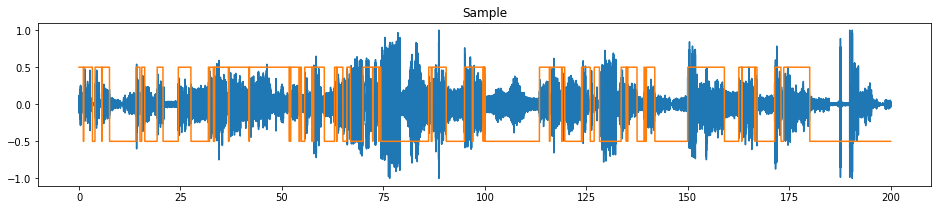

46 % voice 54 % silence


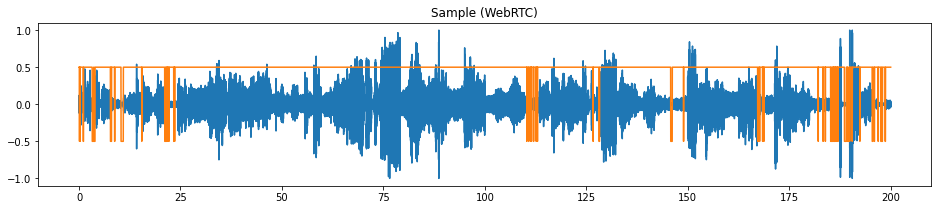

In [32]:
import matplotlib.pyplot as plt

class DataGenerator:
    
    def __init__(self, data, size_limit=0):        
        self.data = data
        self.size = size_limit if size_limit > 0 else len(data['labels'])
        self.data_mode = 0
        
    def set_noise_level_db(self, level, reset_data_mode = True):
        
        if level not in noise_levels_db:
            raise Exception(f'Noise level "{level}" not supported! Options are: {list(noise_levels_db.keys())}')
        
        self.noise_level = level
        
        # переключатель режима подсета и позиции
        if reset_data_mode:
            if self.data_mode == 0:
                self.use_train_data()
            elif self.data_mode == 1:
                self.use_validate_data()
            elif self.data_mode == 2:
                self.use_test_data()
        
    def setup_generation(self, frame_count, step_size, batch_size, val_part=0.1, test_part=0.1):
        
        self.frame_count = frame_count
        self.step_size = step_size
        self.batch_size = batch_size
        
        # задаем индексы и размеры подсетов
        self.train_index = 0
        self.val_index = int((1.0 - val_part - test_part) * self.size)
        self.test_index = int((1.0 - test_part) * self.size)
        
        self.train_size = self.val_index
        self.val_size = self.test_index - self.val_index
        self.test_size = self.size - self.test_index
        
    def use_train_data(self):
        
        # считаем, сколько батчей мы можем собрать с данными параметрами
        n = int((self.train_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.train_index
        self.data_mode = 0
        
    def use_validate_data(self):
        
        n = int((self.val_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.val_index
        self.data_mode = 1
        
    def use_test_data(self):
        
        n = int((self.test_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.test_index
        self.data_mode = 2

    def get_data(self, index_from, index_to):
        frames = self.data['frames-' + self.noise_level][index_from : index_to]
        mfcc = self.data['mfcc-' + self.noise_level][index_from : index_to]
        delta = self.data['delta-' + self.noise_level][index_from : index_to]
        labels = self.data['labels'][index_from : index_to]
        return frames, mfcc, delta, labels
        
    def get_batch(self, index):
        
        # текущая позиция в длинном файле.
        pos = self.initial_pos + (self.batch_size * index) * self.step_size
        
        # собираем необходимые данные.
        l = self.frame_count + self.step_size * self.batch_size
#         print(pos, l)
        frames, mfcc, delta, labels = self.get_data(pos, pos + l)
#         print(frames.shape, mfcc.shape, delta.shape, labels.shape)
        
        x, y, i = [], [], 0
        
        # собираем батчи
        while len(y) < self.batch_size:
            
            X = np.hstack((mfcc[i : i + self.frame_count], delta[i : i + self.frame_count]))
            
            # список фреймов
            x.append(X)
            
            # Лейблом последовательности задаем значение из середины этого лейбла
            y_range = labels[i : i + self.frame_count]
            y.append(int(y_range[int(self.frame_count / 2)]))
            
            
            # Передвигаем окно
            i += self.step_size
        
#         print(np.array(x).shape, np.array(y).shape)
        
        return x, y
        
    def plot_data(self, index_from, index_to, show_track=False):
        
        frames, mfcc, delta, labels = self.get_data(index_from, index_to)
        
        Vis.plot_sample(frames, labels)
        Vis.plot_sample_webrtc(frames)
        
        
# Test
generator = DataGenerator(data, size_limit=10000)

generator.setup_generation(frame_count=3, step_size=1, batch_size=2)
generator.set_noise_level_db('-15')
generator.use_train_data()
X, y = generator.get_batch(0)

print(f'Load a few frames into memory:\n{X[0]}\n\nCorresponding label: {y[0]}')

generator.plot_data(20000, 40000)

# Гиперпараметры тренировки

`FRAMES` задает количество фреймов $\{f_{0}, f_{1}, \ldots ,f_{n}\}$, используемых для предсказания фрейма $f_{n}$.<br/>
`FEATURES` не может превышать количество фичей mfcc+delta (в данном случае 12 + 12)<br/>
`STEP_SIZE` задает, насколько смещается окно по данным в каждой итерации. Маленькое значение дает больше данных, но и больше времени тренировки

In [33]:
BATCH_SIZE = 2048
FRAMES = 30
FEATURES = 24
STEP_SIZE = 6
MAX_EPOCHS = 15

# Архитектура сети

На собеседовании обсуждалась сверточная сетка с GRU модулями, я постарался найти и имплементировать похожую архитектуру. Идея сети, а так же использования Focal Loss взята из статьи Voice Activity Detection in Noisy Environments (Nicklas Hansen and Simon H. Albrechtsen, Retune DSP, 2018) (статья приложена в корне проекта)

### Gated Conv + GRU recurrent layer

In [119]:
from torch.nn import Conv1d, Conv2d, Dropout, LSTM, GRU, BatchNorm1d, BatchNorm2d
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

class BiRNN(nn.Module):
    '''
    Bi-directional layer of gated recurrent units.
    Includes a fully connected layer to produce binary output.
    '''
    def __init__(self, num_in, num_hidden, batch_size = BATCH_SIZE, lstm = False, fcl = True, bidir = False):
        super(BiRNN, self).__init__()
        
        self.num_hidden, self.batch_size = num_hidden, batch_size
        self.lstm, self.bidir, self.layers = lstm, bidir, 2 
        
        if lstm:
            self.hidden = self.init_hidden()
            self.rnn = LSTM(num_in, num_hidden, num_layers=self.layers, bidirectional=self.bidir, batch_first=True)
            sz = 18
        else:
            self.rnn = GRU(num_in, num_hidden, num_layers=self.layers, bidirectional=self.bidir, batch_first=True)
            sz = 18
            
        embed_sz = num_hidden*2 if self.bidir or self.layers > 1 else num_hidden
        
        if not fcl:
            self.embed = nn.Linear(embed_sz, 2)
        else:
            self.embed = nn.Sequential(
                nn.Linear(embed_sz, sz+14),
                nn.BatchNorm1d(sz+14),
                nn.Dropout(p=0.2),
                nn.ReLU(),
                nn.Linear(sz+14, sz),
                nn.BatchNorm1d(sz),
                nn.Dropout(p=0.2),
                nn.ReLU(),
                nn.Linear(sz, 2)
                )
                            
    def init_hidden(self):
        num_dir = 2 if self.bidir or self.layers > 1 else 1
        h = Variable(torch.zeros(num_dir, self.batch_size, self.num_hidden))
        c = Variable(torch.zeros(num_dir, self.batch_size, self.num_hidden))
        
        if OBJ_CUDA:
            h = h.cuda()
            c = c.cuda()
        
        return h, c
        
    def forward(self, x):
        if OBJ_CUDA:
            self.rnn.flatten_parameters()
        
        x = x.permute(0, 2, 1)
        
        if self.lstm:
            x, self.hidden = self.rnn(x, self.hidden)
        else:
            x, self.hidden = self.rnn(x)
            
        x = self.hidden.view(self.batch_size, -1)
        
        # (batch, features)
        return self.embed(x)
    
    
class GatedConv(nn.Module):
    '''
    Gated convolutional layer using tanh as activation and a sigmoidal gate.
    The convolution is padded to keep its original dimensions.
    '''
    def __init__(self, in_channels, out_channels, kernel_size = 3, dilation = 1, padding = True):
        super(GatedConv, self).__init__()
        
        padding = int((kernel_size-1)/2) if padding else 0
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        )
        self.conv_gate = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.conv(x) * self.conv_gate(x)
    

class Conv(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size = 3, dilation = 1, padding = True):
        super(Conv, self).__init__()
        
        padding = int((kernel_size-1)/2) if padding else 0
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.conv(x)
    
     
class GatedResidualConv(nn.Module):
    '''
    Legacy class.
    Gated residual convolutional layer using tanh as activation and a sigmoidal gate.
    Outputs the accumulated input to be used in the following layer, as well as a
    residual connection that is added to the output of the following layer using
    element-wise multiplication. Input and output sizes are unchanged.
    '''
    def __init__(self, channels, kernel_size = 3, dilation = 1):
        super(GatedResidualConv, self).__init__()
        
        self.gated_conv = GatedConv(channels, channels)
        
    def forward(self, x, r = None):
        # Residual connection defaults to x
        if r is None:
            r = x
        out = self.gated_conv(x)
        
        # (acummulated input, residual connection)
        return out * x, out * r
    

class cGRU(nn.Module):
    '''
    This network consists of (gated) convolutional layers,
    followed by a bi-directional recurrent layer and one or
    more fully connected layers. Output is run through a
    softmax function.
    '''
    def __init__(self, residual_connections = False, gated = True, lstm = False,
                 fcl = True, bidir = False, frames = FRAMES, features = FEATURES):
        
        super(cGRU, self).__init__()
        
        self.residual_connections = residual_connections
        

        if gated:
            conv_channels1, conv_channels2, conv_channels3, conv_channels4 = 32, 28, 25, 18
        else:
            conv_channels1, conv_channels2, conv_channels3, conv_channels4 = 38, 35, 31, 24
        conv_channels_out = conv_channels4

        # Gated conv with residual
        if residual_connections:
            conv_channels3 = conv_channels2
            self.conv1 = GatedConv(features, conv_channels3)
            self.conv2 = GatedResidualConv(conv_channels3)
            self.conv3 = GatedResidualConv(conv_channels3)
            self.conv4 = GatedResidualConv(conv_channels3)

        # Gated conv
        elif gated:
            self.conv1 = GatedConv(features, conv_channels1)
            self.conv2 = GatedConv(conv_channels1, conv_channels2)
            self.conv3 = GatedConv(conv_channels2, conv_channels3)
            self.conv4 = GatedConv(conv_channels3, conv_channels4)

        else:
            self.conv1 = Conv(features, conv_channels1)
            self.conv2 = Conv(conv_channels1, conv_channels2)
            self.conv3 = Conv(conv_channels2, conv_channels3)
            self.conv4 = Conv(conv_channels3, conv_channels4)
        
        num_hidden = conv_channels_out + 11
        self.rnn = BiRNN(conv_channels_out, num_hidden, lstm=lstm, fcl=fcl, bidir=bidir)
        
    def forward(self, x):
        # (batch, frames, features)
        x = x.permute(0, 2, 1)
        
        # (batch, features/channels, frames)
        x = self.conv1(x)
        
        if self.residual_connections:
            x,r = self.conv2(x)
            x,r = self.conv3(x, r)
            x,r = self.conv4(x, r)
            x = x * r 
        else:
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
        
        #   (batch, channels, frames)
        # ->(batch, frames, channels)
        x = self.rnn(x)
        
        # (batch, 2)
        return F.softmax(x, dim=1)

gru = cGRU()
print(gru)

cGRU(
  (conv1): GatedConv(
    (conv): Sequential(
      (0): Conv1d(24, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (conv_gate): Sequential(
      (0): Conv1d(24, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sigmoid()
    )
  )
  (conv2): GatedConv(
    (conv): Sequential(
      (0): Conv1d(32, 28, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (conv_gate): Sequential(
      (0): Conv1d(32, 28, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sigmoid()
    )
  )
  (conv3): GatedConv(
    (conv): Sequential(
      (0): Conv1d(28, 25, kernel_size=(3

# Baseline net

In [65]:
class Net(nn.Module):
    
    def __init__(self, large = True, lstm = True):
        super(Net, self).__init__()
    
        self.large = large
        self.lstm = lstm
        self.relu = nn.ReLU()
        
        if lstm:
            self.hidden = self.init_hidden()
            self.rnn = LSTM(input_size=FEATURES, hidden_size=FRAMES, num_layers=1, batch_first=True)
        else:
            self.rnn = GRU(input_size=FEATURES, hidden_size=FRAMES, num_layers=1, batch_first=True)
        
        if large:
            self.lin1 = nn.Linear(FRAMES**2, 26)
            self.lin2 = nn.Linear(26, 2)
        else:
            self.lin = nn.Linear(FRAMES**2, 2)
            
        self.softmax = nn.Softmax(dim=1)
    
    def init_hidden(self):
        h = Variable(torch.zeros(1, BATCH_SIZE, FRAMES))
        c = Variable(torch.zeros(1, BATCH_SIZE, FRAMES))
        
        if OBJ_CUDA:
            h = h.cuda()
            c = c.cuda()
        
        return h, c
    
    def forward(self, x):
        #if OBJ_CUDA:
        #    self.rnn.flatten_parameters()
        
        # (batch, frames, features)
        if hasattr(self, 'lstm') and self.lstm:
            x, _ = self.rnn(x, self.hidden)
        else:
            x, _ = self.rnn(x)
            
        x = x.contiguous().view(-1, FRAMES**2)
        
        # (batch, units)
        if self.large:
            x = self.relu(self.lin1(x))
            x = self.lin2(x)
        else:
            x = self.lin(x)
        
        return self.softmax(x)

net = Net(large=True)
# num_params(net)
print(net)

Net(
  (relu): ReLU()
  (rnn): LSTM(24, 30, batch_first=True)
  (lin1): Linear(in_features=900, out_features=26, bias=True)
  (lin2): Linear(in_features=26, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


# DenseNet

In [122]:
class DenseSingle(nn.Module):

    def __init__(self, input_size, output_size, dropout, dilation, padding, kernel_size, stride):
        super(DenseSingle, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=kernel_size, padding=padding, 
                      stride=stride, dilation=dilation, bias=False),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        out = self.layer(x)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    
    def __init__(self, input_size, n_layers, growth_rate, dropout, dilation, padding, kernel_size, stride):
        super(DenseBlock, self).__init__()
        
        layers = []
        for i in range(n_layers):
            layers.append(DenseSingle(input_size + i * growth_rate, growth_rate, 
                                      dropout, dilation, padding, kernel_size, stride))
        
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):        
        return self.block(x)

class TransitionBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(TransitionBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(output_size),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        return self.layers(x)
    
class DenseNet(nn.Module):
    def __init__(self, large=False):
        super(DenseNet, self).__init__()

        if large:
            
            dropout = 0.4
        
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=48, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(48),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.dense1 = DenseBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.trans1 = TransitionBlock(input_size=80, output_size=48, dropout=dropout)

            self.dense2 = DenseBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=80, out_channels=80, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(80),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.out = nn.Linear(80, 2, bias=False)

            
        else:
        
            dropout = 0.4
        
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=24, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(24),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.dense1 = DenseBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.trans1 = TransitionBlock(input_size=42, output_size=24, dropout=dropout)

            self.dense2 = DenseBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=42, out_channels=42, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(42),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.out = nn.Linear(42, 2, bias=False)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        
        x = self.cnn_in(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.cnn_out(x)
        
        x = x.view(BATCH_SIZE, -1)
     
        return F.softmax(self.out(x), dim=1)

set_seed()
densenet = DenseNet(large=True)
# num_params(densenet)
print(densenet)

DenseNet(
  (cnn_in): Sequential(
    (0): Conv1d(24, 48, kernel_size=(6,), stride=(1,), dilation=(4,), bias=False)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.4, inplace=False)
  )
  (dense1): DenseBlock(
    (block): Sequential(
      (0): DenseSingle(
        (layer): Sequential(
          (0): Conv1d(48, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Dropout(p=0.4, inplace=False)
        )
      )
      (1): DenseSingle(
        (layer): Sequential(
          (0): Conv1d(52, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [123]:
generator = DataGenerator(data)
generator.setup_generation(frame_count=FRAMES, step_size=STEP_SIZE, batch_size=BATCH_SIZE)
generator.use_train_data()
generator.set_noise_level_db('None')

print(generator.batch_count, 'training batches were found.')

def accuracy(out, y):
    '''
    Calculate accuracy of model
    '''
    out = torch.max(out, 1)[1].float()
    eq = torch.eq(out, y.float()).float()
    return torch.mean(eq)

# Compact instantiation of untrained network on CPU
temp, OBJ_CUDA = OBJ_CUDA, False
densenet, OBJ_CUDA = DenseNet(large=True), temp
del temp

# Run a few batches
for i in range(3):
    
    # Get batch
    X, y = generator.get_batch(i)
    X = torch.from_numpy(np.array(X)).float().cpu()
    y = torch.from_numpy(np.array(y)).cpu()

    # Run through network
    out = densenet(X)
    acc = accuracy(out, y).data.numpy()

print('Successfully ran the network!\n\nExample output:', out.data.numpy()[0])

252 training batches were found.
Successfully ran the network!

Example output: [0.88186705 0.11813288]


### Focal Loss


Focal loss является разновидностью кросс-энтропийного лосса с множителем $(1-p)^{\gamma}$

$FL(p_t) = -(1-p_t)^{\gamma}~\log(p_t)$

где $p_t$ - вероятность ground truth. Для $\gamma > 0$, the loss for well-classified samples is reduced, which in turn forces the optimizer to pay more attention to badly-classified samples. In the context of our study, FL serves to gradually decrease influence of easy samples (typically samples with little background noise) during training.

Для $\gamma > 0$ лосс верно классифицированных сэмплов уменьшается, что заставляет классификатор уделять больше внимания неверно классифицированным. Здесь focal loss нужен, чтобы уменьшать влияние простых семплов (с низким уровнем шума, например).

Статья по FL - https://arxiv.org/abs/1708.02002, код отсюда https://github.com/clcarwin/focal_loss_pytorch

In [40]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=0)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

# Тренировка

### Training setup

`train_net` прогоняет сетку, используя данные, генерируемые  `DataGenerator`.<br/>

In [64]:
import torch.optim as optim
from IPython.display import clear_output
import time

NOISE_LEVELS = ['None', '-15', '-3']

def net_path(epoch, title):
    part = os.getcwd() + '/models/' + title
    if epoch >= 0:
        return part + '_epoch' + str(epoch).zfill(3) + '.net'
    else:
        return part + '.net'

def save_net(net, epoch, title = 'net'):
    if not os.path.exists(os.getcwd() + '/models'):
        os.makedirs(os.getcwd() + '/models')
    torch.save(net, net_path(epoch, title))
    
def load_net(epoch = MAX_EPOCHS-1, title = 'cGRU'):
    if OBJ_CUDA:
        return torch.load(net_path(epoch, title))
    else:
        return torch.load(net_path(epoch, title), map_location='cpu')

def train_net(net, data, size_limit = 0, noise_level = 'None', epochs = MAX_EPOCHS, lr = 1e-3, use_adam = True,
              weight_decay = 1e-5, momentum = 0.9, use_focal_loss = True, gamma = 0.0,
              early_stopping = False, patience = 25, frame_count = FRAMES, step_size = STEP_SIZE,
              auto_save = True, title = 'net', verbose = True):

    
    # Задаем генератор
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(frame_count, step_size, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.train_size == 0:
        print('Error: no training data was found!')
        return
    
    if OBJ_CUDA:
        print('cuda ', OBJ_CUDA)
        net.cuda()
        
    # Можно тренировать и на кросс-энтропию
    if use_focal_loss:
        criterion = FocalLoss(gamma)
        levels = NOISE_LEVELS
    else:
        criterion = nn.CrossEntropyLoss()
        levels = [noise_level]
    
    if OBJ_CUDA:
        criterion.cuda()
    
    if use_adam:
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    if verbose:
        print(net)
        print(f'Initiating training of {title}...\n\nLearning rate: {lr}')
        _trsz = generator.train_size*3 if use_focal_loss else generator.train_size
        _vlsz = generator.val_size*3 if use_focal_loss else generator.val_size
        print(f'Model parameters: {sum(p.numel() for p in net.parameters())}')
        print(f'Frame partitions: {_trsz} | {_vlsz}')
        _critstr = f'Focal Loss (γ = {gamma})' if use_focal_loss else f'Cross-Entropy ({noise_level} dB)'
        _optmstr = f'Adam (decay = {weight_decay})' if use_adam else f'SGD (momentum = {momentum})'
        _earlstr = f'Early Stopping (patience = {patience})' if early_stopping else str(epochs)
        _autostr = 'Enabled' if auto_save else 'DISABLED'
        print(f'Criterion: {_critstr}\nOptimizer: {_optmstr}')
        print(f'Max epochs: {_earlstr}\nAuto-save: {_autostr}')
    
    net.train()
    stalecount, maxacc = 0, 0
    
    def plot(losses, accs, val_losses, val_accs):
        '''
        Строит обновляемые графики лоссов и метрик (если verbose)
        '''
        clear_output(wait=True)
        e = [i for i in range(len(losses))]
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(e, losses, label='Loss (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_losses, label='Loss (Validation)')
            
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(e, accs, label='Accuracy (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_accs, label='Accuracy (Validation)')
            
        plt.legend()
        plt.show()
        
        
    def run(net, optimize = False):
        '''
        Прогон одной эпохи. Фреймы закидываются генераторами по мере необходимости,
        не тратя память. Возвращает средний лосс и accuracy
        '''
        epoch_loss, epoch_acc, level_acc = 0, [], []
        
        #Если мы используем фокал лосс, то нужны все уровни шума
        batches = generator.batch_count
        print('batches in run ', batches)
        num_batches = batches*len(levels)
        print('num_batches in run ', num_batches)
        
        if num_batches == 0:
            raise ValueError('Not enough data to create a full batch!')
        
        # Хелпер для прогона батча
        def run_batch(X, y, epoch_loss, epoch_acc):

            X = Variable(torch.from_numpy(np.array(X)).float())
            y = Variable(torch.from_numpy(np.array(y))).long()

            if OBJ_CUDA:
                X = X.cuda()
                y = y.cuda()

            out = net(X)
#             print('net_out in run_batch', out.shape)

            batch_loss = criterion(out, y)
            batch_acc = accuracy(out, y)

            # В тренировке считаем бэкпроп и оптимизатор
            if optimize == True:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            if OBJ_CUDA:
                batch_acc = batch_acc.cpu()
                batch_loss = batch_loss.cpu()

            # Accumulate loss and accuracy for epoch metrics
            epoch_loss += batch_loss.data.numpy() / float(BATCH_SIZE)
            epoch_acc.append(batch_acc.data.numpy())

            return epoch_loss, epoch_acc
        
        # для всех заданных уровней шума
        for lvl in levels:
            
            # подстраиваем генератор под уровень шума
            generator.set_noise_level_db(lvl)
            
            for i in range(batches):

                X, y = generator.get_batch(i)
#                 print('get_batch_train/val ', np.array(X).shape, np.array(y).shape)
                temp_loss, temp_acc = run_batch(X, y, epoch_loss, epoch_acc)
                epoch_loss += temp_loss / float(num_batches)
                level_acc.append(np.mean(temp_acc))

        return epoch_loss, np.mean(level_acc)
    
    losses, accs, val_losses, val_accs = [], [], [], []
    
    if verbose:
        start_time = time.time()
    
    # итерируемся по всем эпохам
    for epoch in range(epochs):
        
        # считаем лосс и accuracy для эпохи и оптимизируем по ним
        generator.use_train_data()
        loss, acc = run(net, optimize=True)
        print(loss, loss)
        losses.append(loss)
        accs.append(acc)
        
        # Если генератор валидации не кончился, считаем метрики валидации
        if generator.val_size != 0:
            net.eval()
            generator.use_validate_data()
            val_loss, val_acc = run(net)
            print(val_loss, val_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            net.train()
            
            # Если задан early stop, то чекаем, не застряла ли accuracy валидации, иначе останавливаем
           
            if epoch > 0 and val_accs[-1] <= maxacc:
                stalecount += 1
                if stalecount > patience and early_stopping:
                    return
            else:
                stalecount = 0
                maxacc = val_accs[-1]
        
        if auto_save:
            save_net(net, epoch, title)
        
        # Строим график метрик, если надо
        if verbose:             
            plot(losses, accs, val_losses, val_accs)

### Сид генерации

Для повторимости экспериментов задаем сиды для торча и нампая

In [42]:
def set_seed(seed = 666):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if OBJ_CUDA:
        torch.cuda.manual_seed_all(seed)

# Метрики

### ROC кривая
Считаем ROC и AUC по всем шумам на тест-сете из генератора

In [97]:
from sklearn import metrics

def test_predict(net, data, size_limit, noise_level):
    '''
    Вычисляет предсказания на тесте
    '''
    
    # Датагенератор со стандартными параметрами
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    y_true, y_score = [], []
#     print('batches in test_predict ', generator.batch_count)

    for i in range(generator.batch_count):

        X, y = generator.get_batch(i)
        
        X = Variable(torch.from_numpy(np.array(X)).float())
        y = Variable(torch.from_numpy(np.array(y))).long()
#         print('batches shape in test_predict ', X.shape, y.shape)

        if OBJ_CUDA:
            X = X.cuda()

        out = net(X)
        
#         print('net out in test_predict ', out.shape)

        if OBJ_CUDA:
            out = out.cpu()
            y = y.cpu()

        #ground-truth лейблы
        y_true.extend(y.data.numpy())

        # Насчитанные сеткой вероятностные лейблы
        y_score.extend(out.data.numpy()[:,1])
    
    return y_true, y_score
    


def roc_auc(net, data, noise_lvl, size_limit = 0):
    plt.figure(1, figsize=(16, 10))
    plt.title('Receiver Operating Characteristic (%s)' % noise_lvl, fontsize = 16)
    print('roc_auc')
        
    # предсказания
    y_true, y_score = test_predict(net, data, size_limit, noise_lvl)

    # считаем ROC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc_res = metrics.auc(fpr, tpr)

    # строим 
    plt.plot(fpr, tpr, label='(AUC = %0.3f)' % (auc_res))

#     plt.xlim([0, 0.2])
#     plt.ylim([0.6, 1])
    plt.ylabel('True Positive Rate', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right', prop={'size': 16})
    plt.show()

### Подсчет порогов
Считаем заданные в ТЗ пороги - первый для FA=1%, второй для FR=1% и третий FA=FR

In [ ]:
# !pip install bob

In [93]:
from sklearn.metrics import confusion_matrix
import math

def reject_metrics(net, data, size_limit = 0, frr = 1, far = 1, plot = True):
    '''
    Computes the confusion matrix for a given network.
    '''
    
    # Применяем трешхолды к предиктам
    def apply_threshold(y_score, t = 0.5):
        return [1 if y >= t else 0 for idx, y in enumerate(y_score)]
    
    def fix_frr(y_true, y_score, frr_target, noise_level):
        
        # костыль
        if noise_level == 'None':
            t = 1e-4
        elif noise_level == '-15':
            t = 1e-5
        else:
            t = 1e-9
        
        # фиксированный FR
        while t < 1.0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            
            if frr >= frr_target:
                return far, frr, t
            
            t *= 1.1
    
        # Возвращаем самый похожий результат, если нет совпадений
        return far, frr, t
    
    def fix_far(y_true, y_score, far_target):
        
        t = 1.2
        
        # фиксированный FА
        while t > 0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            if far >= far_target:
                return far, frr, t
            
            t *= 0.999
    
        return far, frr, t
    
    def eer(y_true, y_score):
        fpr, tpr, threshold = metrics.roc_curve(y_true, y_score, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        
        return EER, eer_threshold

    print('Network metrics:')

    # для каждого уровня шума
    for lvl in NOISE_LEVELS:
        
        y_true, y_score = test_predict(net, data, size_limit, lvl)
        ffr = fix_frr(y_true, y_score, frr, lvl)
        ffa = fix_far(y_true, y_score, far)
        fafr = eer(y_true, y_score)
        
        
        print(f'FAR: {ffr[0]}% for fixed FRR at {ffr[1]}% with threshhold {ffr[2]} and noise level', lvl)
        print(f'FRR: {ffa[0]}%  for fixed FAR at {ffa[0]}%  with threshhold {ffr[0]}%  and noise level', lvl)
        print(f'EER: {fafr[0]}% with threshhold {fafr[1]} and noise level', lvl)

# Подсчет лейбла на рандомном сэмпле из даталоадера

In [112]:
def netvad(net, data, noise_level = '-3', init_pos = 2000, length = 1000, only_plot_net = False):
    '''
    Generates a sample of specified length and runs it through
    the given network. By default, the network output is plotted
    alongside the original labels and WebRTC output for comparison.
    '''
    
    # Set up an instance of data generator using default partitions
    generator = DataGenerator(data)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    raw_frames, mfcc, delta, labels = generator.get_data(init_pos, init_pos+length) # можно просто доставать файл здесь и считать mfcc по нему

    # Convert sample to list of frames
    def get_frames():
        i = 0
        while i < length-FRAMES:
            yield np.hstack((mfcc[i : i + FRAMES], delta[i : i + FRAMES]))
            i += 1
        
        
    # Creates batches from frames
    frames = list(get_frames())
    batches, i, num_frames = [], 0, -1
    while i < len(frames):
        full = i+BATCH_SIZE >= len(frames)
        end = i+BATCH_SIZE if not full else len(frames)
        window = frames[i:end]
        if full:
            num_frames = len(window)
            while len(window) < BATCH_SIZE:
                window.append(np.zeros((FRAMES, FEATURES)))
        batches.append(np.stack(window))
        i += BATCH_SIZE
        
    # Predict for each frame
    offset = 15
    accum_out = [0] * offset
    for batch in batches:
        X = Variable(torch.from_numpy(batch).float())
        if OBJ_CUDA:
            out = torch.max(net(X.cuda()), 1)[1].cpu().float().data.numpy()
        else:
            out = torch.max(net(X), 1)[1].float().data.numpy()
        accum_out.extend(out)
        

    # Adjust padding
    if num_frames > 0:
        accum_out = accum_out[:len(accum_out)-(BATCH_SIZE-num_frames)]
    accum_out = np.array(accum_out)
    
    frames = np.array(frames)
    
    # Cut frames outside of prediction boundary
    raw_frames = raw_frames[offset:-offset]
    labels = labels[offset:-offset]
    accum_out = accum_out[offset:]

    # Plot results
    print('Displaying results for noise level:', noise_level)
    if not only_plot_net:
        Vis.plot_sample(raw_frames, labels, show_distribution = False)
        Vis.plot_sample_webrtc(raw_frames, sensitivity = 0)
    Vis.plot_sample(raw_frames, accum_out, title = 'Sample (Neural Net)', show_distribution = False)

# Тренировка и метрики

Если `OBJ_TRAIN_MODELS` включен, прогоняется тренировка. Если выключен - подгружается натренированная модель из path_peer/models/название модели

Затем считаются все заданные выше метрики.


ROC Curves:
roc_auc


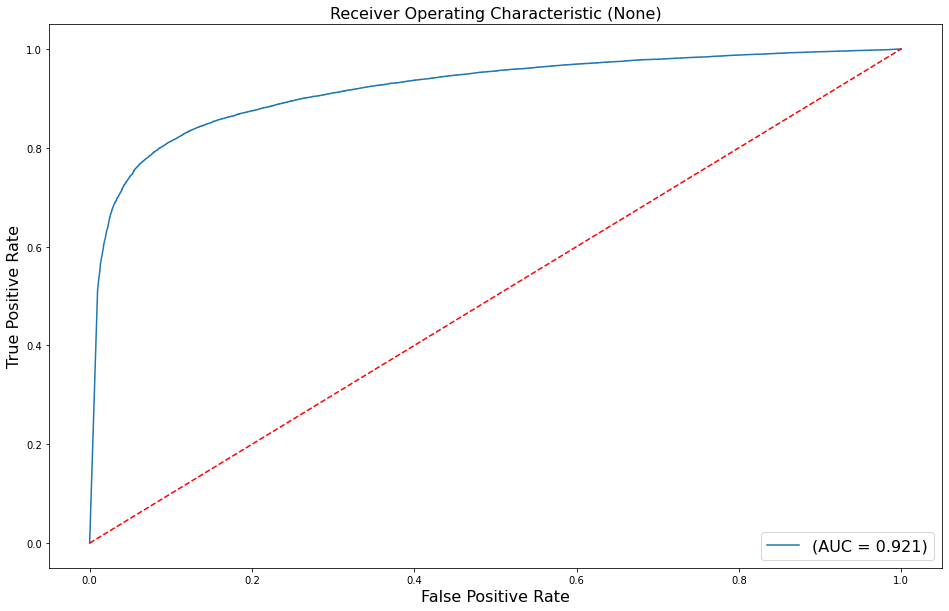

roc_auc


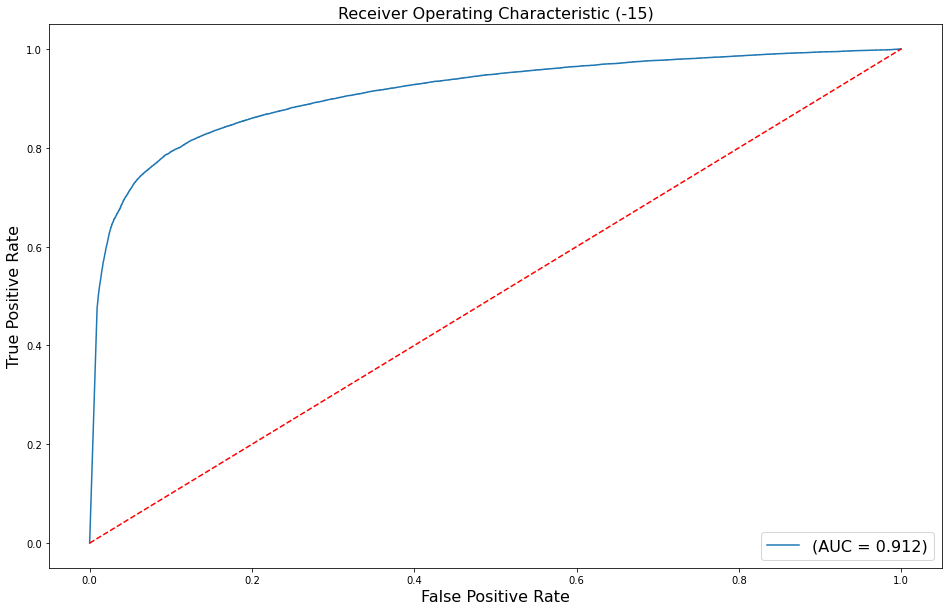

roc_auc


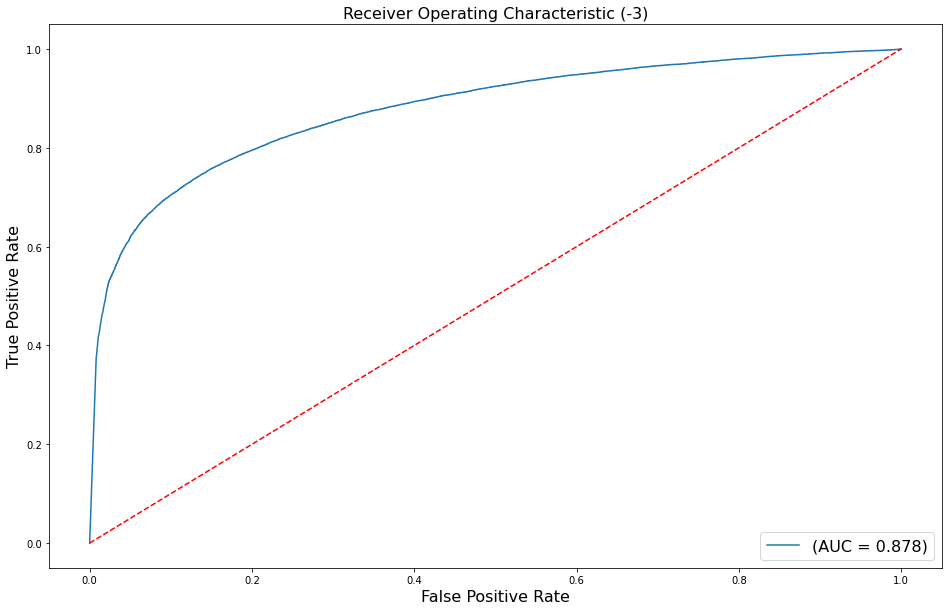

roc_auc


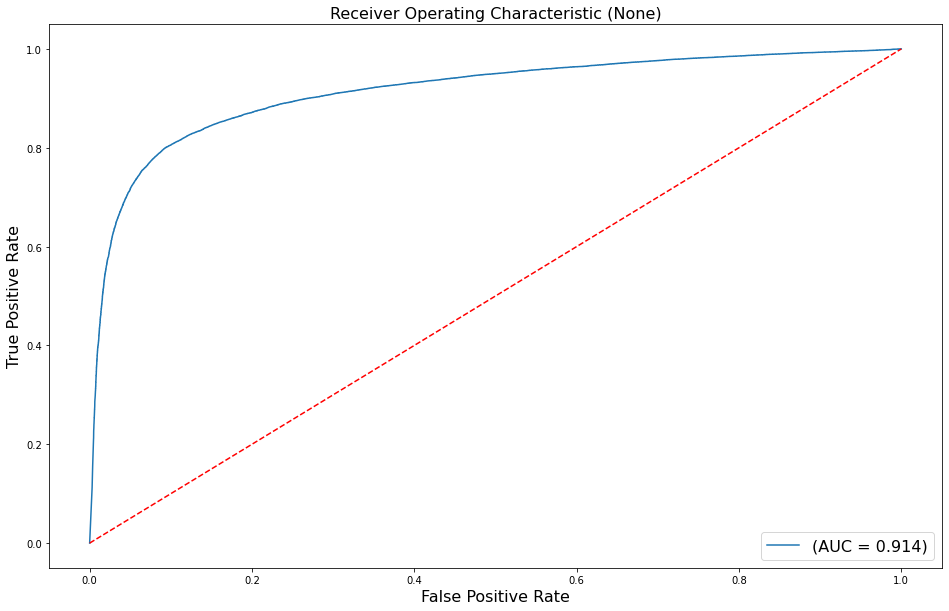

roc_auc


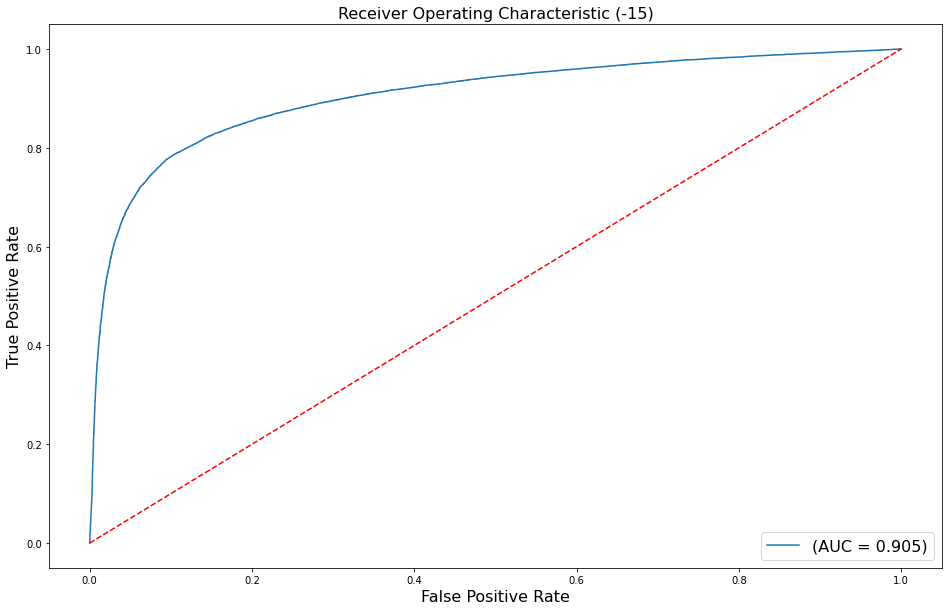

roc_auc


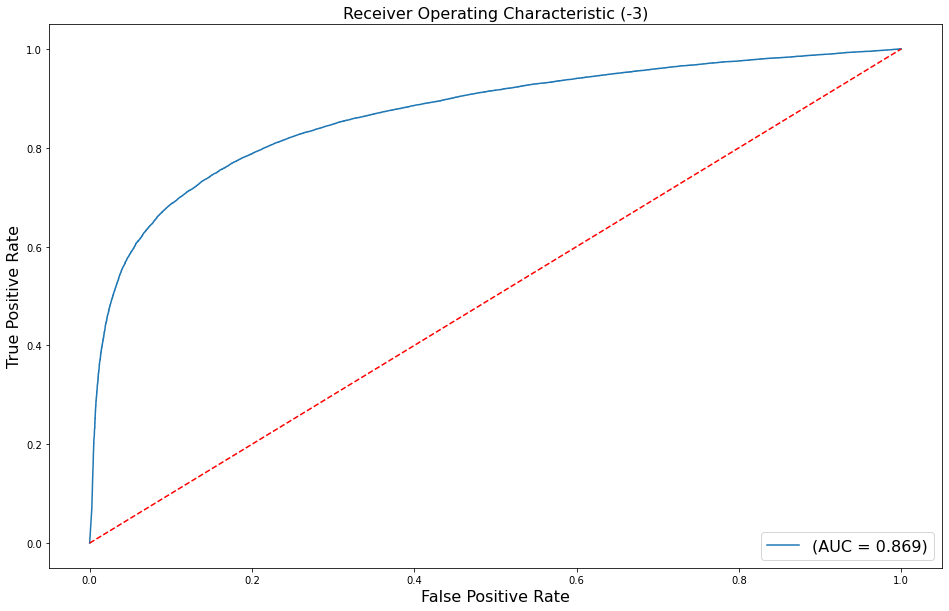


Tresholds:

Net:
Network metrics:
FAR: 39.40155388036854% for fixed FRR at 6.488827299497662% with threshhold 0.0001 and noise level None
FRR: 3.725846980330994%  for fixed FAR at 3.725846980330994%  with threshhold 39.40155388036854%  and noise level None
EER: 0.14932270456055224% with threshhold 0.16664603352546692 and noise level None
FAR: 47.17384397654738% for fixed FRR at 5.612333275593279% with threshhold 1e-05 and noise level -15
FRR: 3.6132050948791266%  for fixed FAR at 3.6132050948791266%  with threshhold 47.17384397654738%  and noise level -15
EER: 0.16119342633509517% with threshhold 0.10865053534507751 and noise level -15
FAR: 79.74179013950264% for fixed FRR at 2.0474623246145853% with threshhold 1e-09 and noise level -3
FRR: 3.2492851572654016%  for fixed FAR at 3.2492851572654016%  with threshhold 79.74179013950264%  and noise level -3
EER: 0.20304421916067353% with threshhold 0.027799410745501518 and noise level -3

DenseNet:
Network metrics:
FAR: 32.94053086098836% 

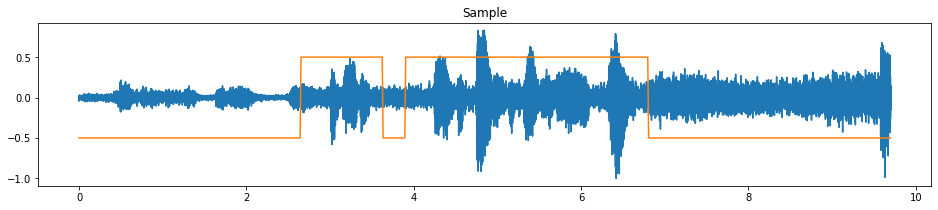

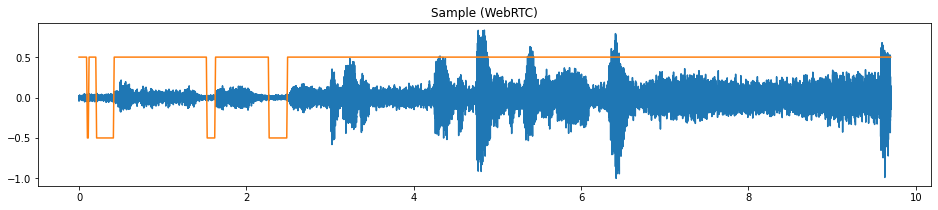

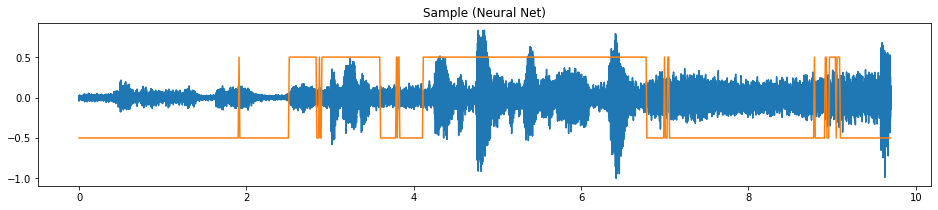


densenet:
Network processed 2048 frames (30s) in 155ms on GPU.
Displaying results for noise level: -3


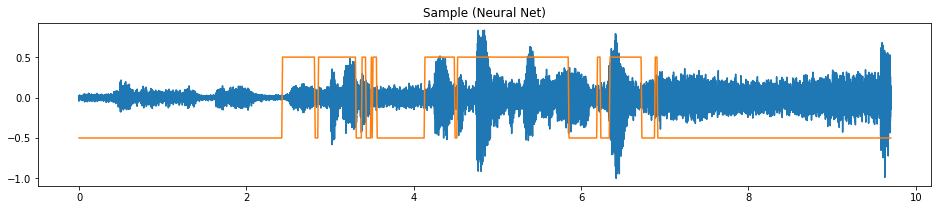

In [127]:
OBJ_TRAIN_MODELS = False
if OBJ_TRAIN_MODELS:
    
#     set_seed()
#     gru = cGRU()
#     train_net(gru, data, title='cGRU', gamma=2)
    
#     set_seed()
#     net = Net(large=True)
#     train_net(net, data, title='Net', gamma=2)

    set_seed()
    densenet = DenseNet(large=True)
    train_net(densenet, data, title='DenseNet', gamma=2)
    
    
else:
    
#     gru = load_net(title='cGRU')
    net = load_net(title='Net')
    gru = load_net(title='densenet')



print('\nROC Curves:')

roc_auc(net, data, 'None')
roc_auc(net, data, '-15')
roc_auc(net, data, '-3')

# roc_auc(gru, data, 'None')
# roc_auc(gru, data, '-15')
# roc_auc(gru, data, '-3')

roc_auc(densenet, data, 'None')
roc_auc(densenet, data, '-15')
roc_auc(densenet, data, '-3')


print('\nTresholds:')

print('\nNet:')
reject_metrics(net, data, frr=1, far=1)

print('\nDenseNet:')
reject_metrics(densenet, data, frr=1, far=1)


print('\nQualitative results:')

print('\nNet:')
netvad(net, data, only_plot_net=False)

print('\ndensenet:')
netvad(densenet, data, only_plot_net=True)
